## Flower Image Classification Project

### 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기

**Step1. Datasets download**

In [265]:
import warnings
warnings.filterwarnings("ignore")

In [266]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [267]:
import tensorflow_datasets as tfds

tfds.__version__

'3.2.1'

In [268]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


In [269]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


- 모든 데이터셋은 (image, label)의 형태를 가집니다.
- ((None, None, 3), ())가 이를 나타내죠.
- **=> (None, None, 3)**은 **image의 shape**를, **뒤의 ()**는 **정답 카테고리인 label의 shape**를 의미합니다.   
<br/>
- 여기에서 이미지는 (height, width, channel)로 3차원 데이터
- (None, None, 3)과 같이 나타났습니다. 
- **Q. 이 때 height와 width => None으로 나타난 이유는 무엇일까요?**
- A. 모든 이미지의 크기가 전부 다르기 때문입니다. 정해져있지 않은 사이즈이기 때문에 None으로 나타낸 거죠.   

**step2. Datasets을 모델에 넣을 수 있는 형태로 준비**
- 이미지를 모두 같은 크기로 formatting
- train_batches, validation_batches, test_batches 준비

In [270]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

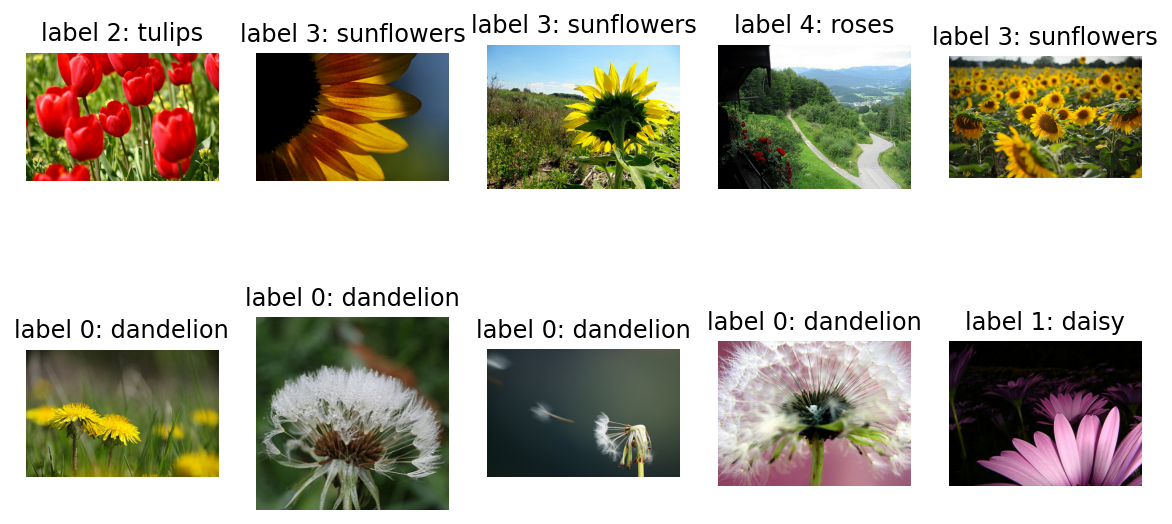

In [271]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

- **raw_train** 안에 있는 데이터를 확인해 보기 위해 **tf.data.Dataset**에서 제공하는 **take**라는 함수를 사용
- 이 함수는 인수로 받은 만큼의 개수만큼의 데이터를 추출하여 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수
- 강아지: label 1, 고양이: label 0
- **=> 모델 학습 시 이미지 사이즈를 통일시켜주는 작업 진행 해야함**

In [272]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

- 위 코드는 이미지의 사이즈를 160x160 픽셀로 통일시킬뿐만 아니라
- 각 픽셀 값의 scale을 수정해주는 역할
- **Q. 픽셀값은 RGB 색을 나타날 때 0~255 사이의 정수값, 위 코드 실행 시 각 픽셀 값 범위는 ?** 
- A. 각 픽셀 범위는 **-1 ~ 1**

In [273]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [274]:
metadata.features['label']    # 클래스 5개 확인

ClassLabel(shape=(), dtype=tf.int64, num_classes=5)

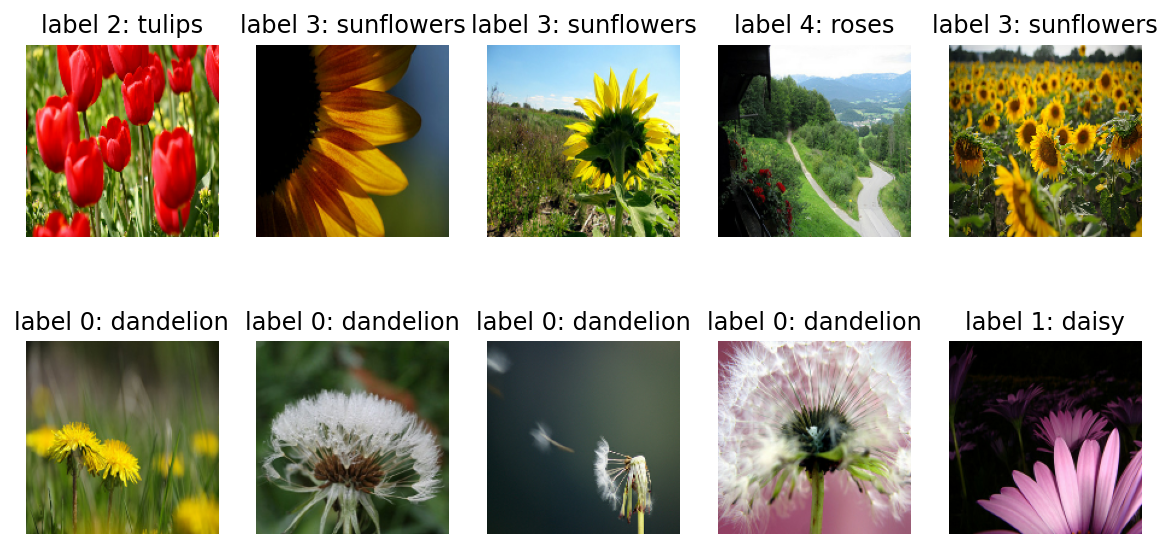

In [275]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

- 모든 이미지의 크기가 160x160으로 동일해짐
- **IMG_SIZE**를 160으로 지정하여 모든 이미지 크기를 (160, 160, 3)으로 통일

- 그 후 BATCH_SIZE에 따라 32개의 데이터를 랜덤으로 뿌려줄 train_batches, validation_batches, test_batches를 만들어 주겠습니다.
- train_batches는 모델이 끊임없이 학습할 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공해 줄 것입니다.

In [276]:
BATCH_SIZE = 32                  # 한 스텝에 학습시킬 데이터 개수
SHUFFLE_BUFFER_SIZE = 1000       # 학습데이터를 적절히 섞어 줌

In [277]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [278]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

**step3. 모델 설계하기**

In [279]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [237]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG19
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

- 방금 이미 잘 학습된 모델을 가져 온 것임
- 이 모델은 입력된 이미지를 입력받으면 해당 이미지의 특징을 잘 뽑아낸 특징 벡터를 추출

In [280]:
image_batch.shape     # 학습할 때 사용했던 데이터를 넣기 전 사이즈 확인

TensorShape([32, 160, 160, 3])

In [281]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

- 이미지 개수는 32개로 동일 / 이미지 사이즈는 160 -> 5 변화 / 체널 3 -> 512 변화
- 이 벡터는 이미지에서 특징을 추출해 낸 "특징 벡터"라고 부름

In [282]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [283]:
import numpy as np

image = np.array([[1, 2],
                  [3, 4]])

flattened_image = image.flatten()

print("Original image:\n", image)
print("Original image shape:", image.shape)
print()
print("Flattened image:\n", flattened_image)
print("Flattened image shape:", flattened_image.shape)

Original image:
 [[1 2]
 [3 4]]
Original image shape: (2, 2)

Flattened image:
 [1 2 3 4]
Flattened image shape: (4,)


- 2차원 or 3차원 벡터 -> 1차원 벡터로 축소 시키는 방법
- Flattening 하는 것 보다 더 좋은 방법이 있음  
**=> Global Verage Pooling**

*Global Average Pooling 계층 만드는 코드 확인

In [284]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [285]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 512)


In [286]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')


#개와 고양이의 예측인 경우 2개의 Class, 꽃 Class의 경우 5개


# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 5)


- 우리의 데이터들은 처음에 이미지에서 특징을 추출해 줄 **VGG16**, **base_model**에 입력되어 특징이 추출된 다음
- 그 특징벡터는 **global_average_layer**를 거쳐 마지막에 **prediction_layer**까지 통과하며 강아지인지, 고양이인지 예측이 될 것입니다.
- **VGG16**에 해당하는 **base_model**은 학습을 시키지 않을 예정이니 학습 여부를 결정하는 **trainable 변수를 False로 지정해 "꺼주겠"습니다.**

In [287]:
from tensorflow.keras.layers import BatchNormalization
Batch_Normalization_layer = tf.keras.layers.BatchNormalization()

#Batch_Normalization_layer

In [288]:
base_model.trainable = False

In [289]:
# 최정 모델 만들기
model = tf.keras.Sequential([base_model, global_average_layer, dense_layer, Batch_Normalization_layer, prediction_layer])

#Batch_Normalization_layer 추가 여부

In [290]:
model.summary()    # 모델 구조 확인

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 2565      
Total params: 14,981,957
Trainable params: 266,245
Non-trainable params: 14,715,712
_________________________________________________________________


- VGG16 안에는 위에서 봤던 매우 복잡한 레이어들이 들어있는데
- 우리가 base_model로 추상화시켰기 때문에 간결하게 나타납니다.
- 모델이 완성되었으니, 이제 학습만 시키면 됨!

**Step 4. 모델 학습시키기**

In [291]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [292]:
validation_steps=10
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 1s 57ms/step - loss: 1.7699 - accuracy: 0.1813
initial loss: 1.77
initial accuracy: 0.18


In [293]:
EPOCHS = 10   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 7s 78ms/step - loss: 1.0351 - accuracy: 0.6144 - val_loss: 1.2879 - val_accuracy: 0.4033
Epoch 2/10
92/92 [==============================] - 7s 75ms/step - loss: 0.6517 - accuracy: 0.7687 - val_loss: 0.9500 - val_accuracy: 0.7384
Epoch 3/10
92/92 [==============================] - 7s 75ms/step - loss: 0.5465 - accuracy: 0.8134 - val_loss: 0.7247 - val_accuracy: 0.8065
Epoch 4/10
92/92 [==============================] - 8s 82ms/step - loss: 0.4764 - accuracy: 0.8270 - val_loss: 0.5661 - val_accuracy: 0.8283
Epoch 5/10
92/92 [==============================] - 8s 82ms/step - loss: 0.4307 - accuracy: 0.8546 - val_loss: 0.5267 - val_accuracy: 0.8147
Epoch 6/10
92/92 [==============================] - 7s 77ms/step - loss: 0.3924 - accuracy: 0.8651 - val_loss: 0.4749 - val_accuracy: 0.8338
Epoch 7/10
92/92 [==============================] - 7s 77ms/step - loss: 0.3641 - accuracy: 0.8784 - val_loss: 0.4620 - val_accuracy: 0.8338
Epoch 8/10
92

**Step 5. 모델 성능 평가**
- 학습 시킨 모델 시각화
- prediction 값들을 실제 추론한 라벨로 변환
- 정답 맞춘 개수 비율

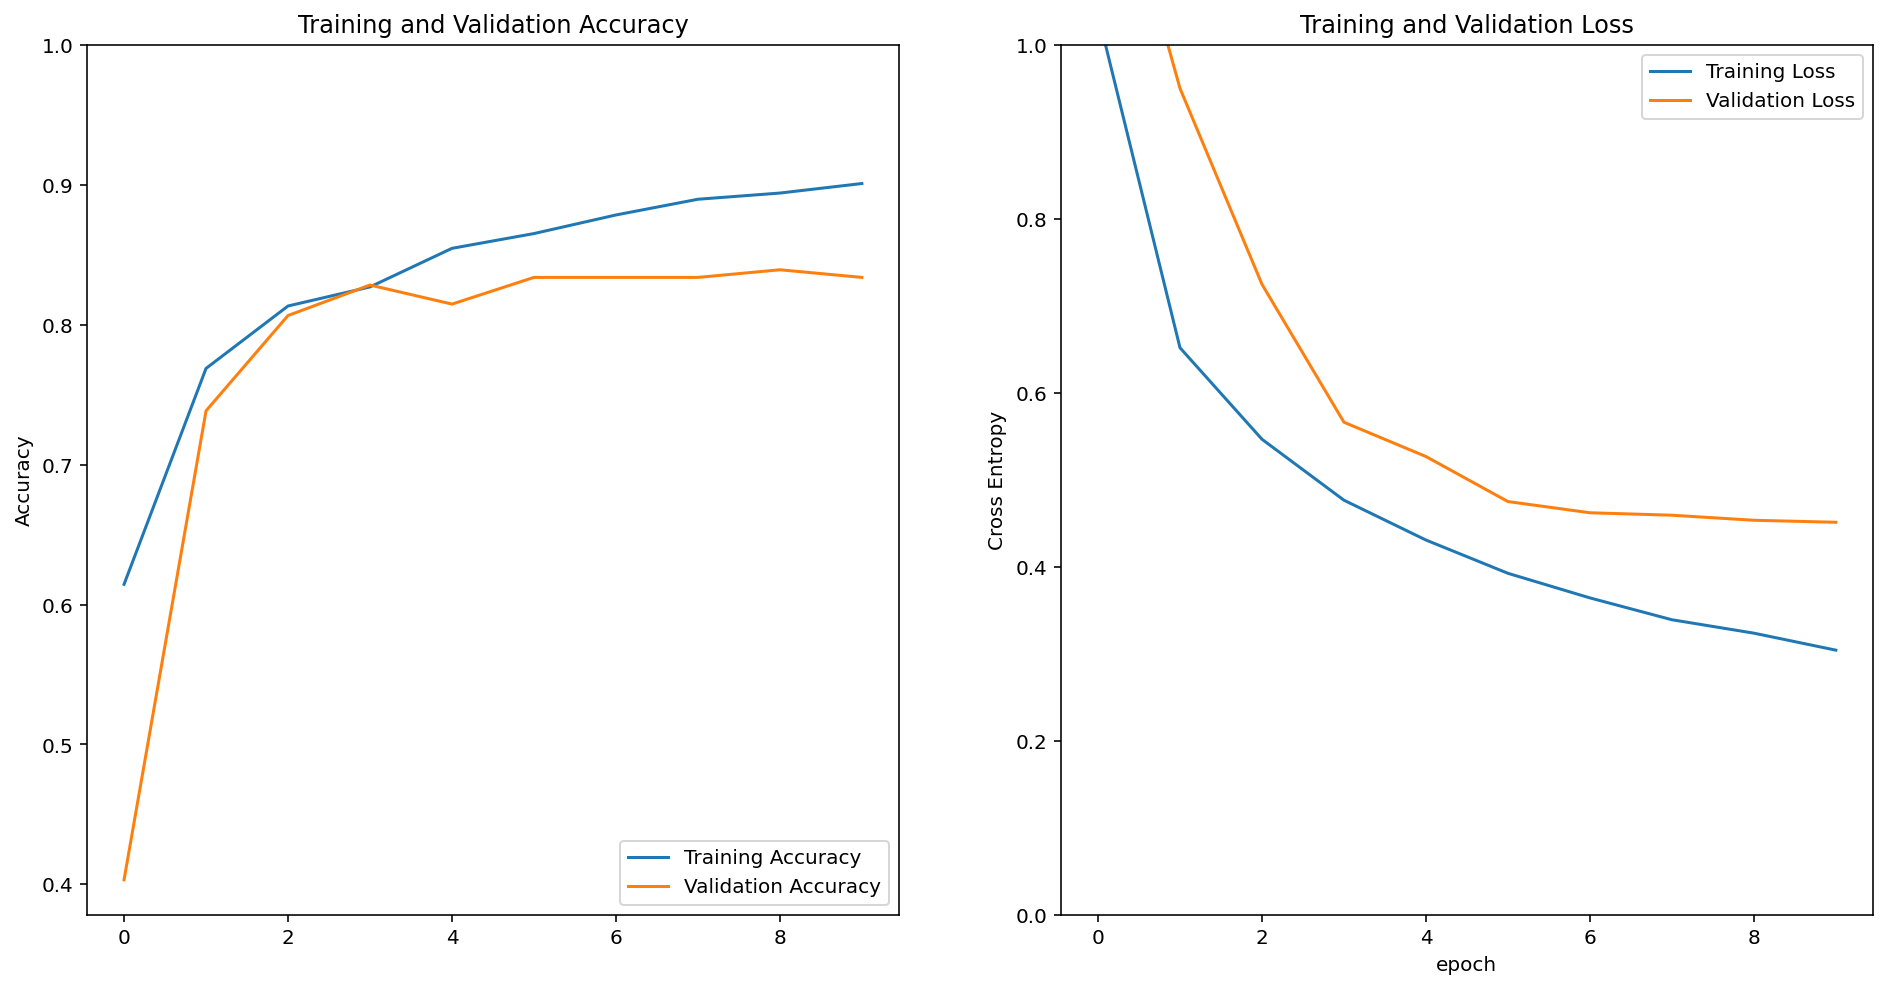

In [294]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [295]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[2.01535458e-03, 1.83298793e-02, 7.69639134e-01, 1.44579196e-02,
        1.95557714e-01],
       [9.99342978e-01, 5.76901948e-04, 5.05969911e-06, 7.09585265e-06,
        6.79252771e-05],
       [4.90487695e-01, 1.54438019e-01, 3.81757654e-02, 2.80142218e-01,
        3.67562249e-02],
       [2.99464999e-04, 1.13724114e-03, 6.62859082e-01, 6.33103773e-04,
        3.35071117e-01],
       [7.65332818e-01, 1.83872670e-01, 1.70168187e-02, 1.11529445e-02,
        2.26247199e-02],
       [9.62049723e-01, 2.56904941e-02, 3.80054652e-03, 7.85245560e-03,
        6.06690824e-04],
       [9.48546105e-04, 2.41753552e-03, 9.74602461e-01, 8.13452248e-03,
        1.38968006e-02],
       [1.21970132e-01, 8.58560801e-01, 3.22448090e-04, 1.64513029e-02,
        2.69526616e-03],
       [3.11633165e-04, 7.31116088e-05, 9.48112272e-03, 9.78238881e-01,
        1.18951621e-02],
       [9.98561084e-01, 1.33686129e-03, 3.68390938e-05, 1.77374277e-05,
        4.74908666e-05],
       [9.86291468e-01, 1.1267

In [296]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 2, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

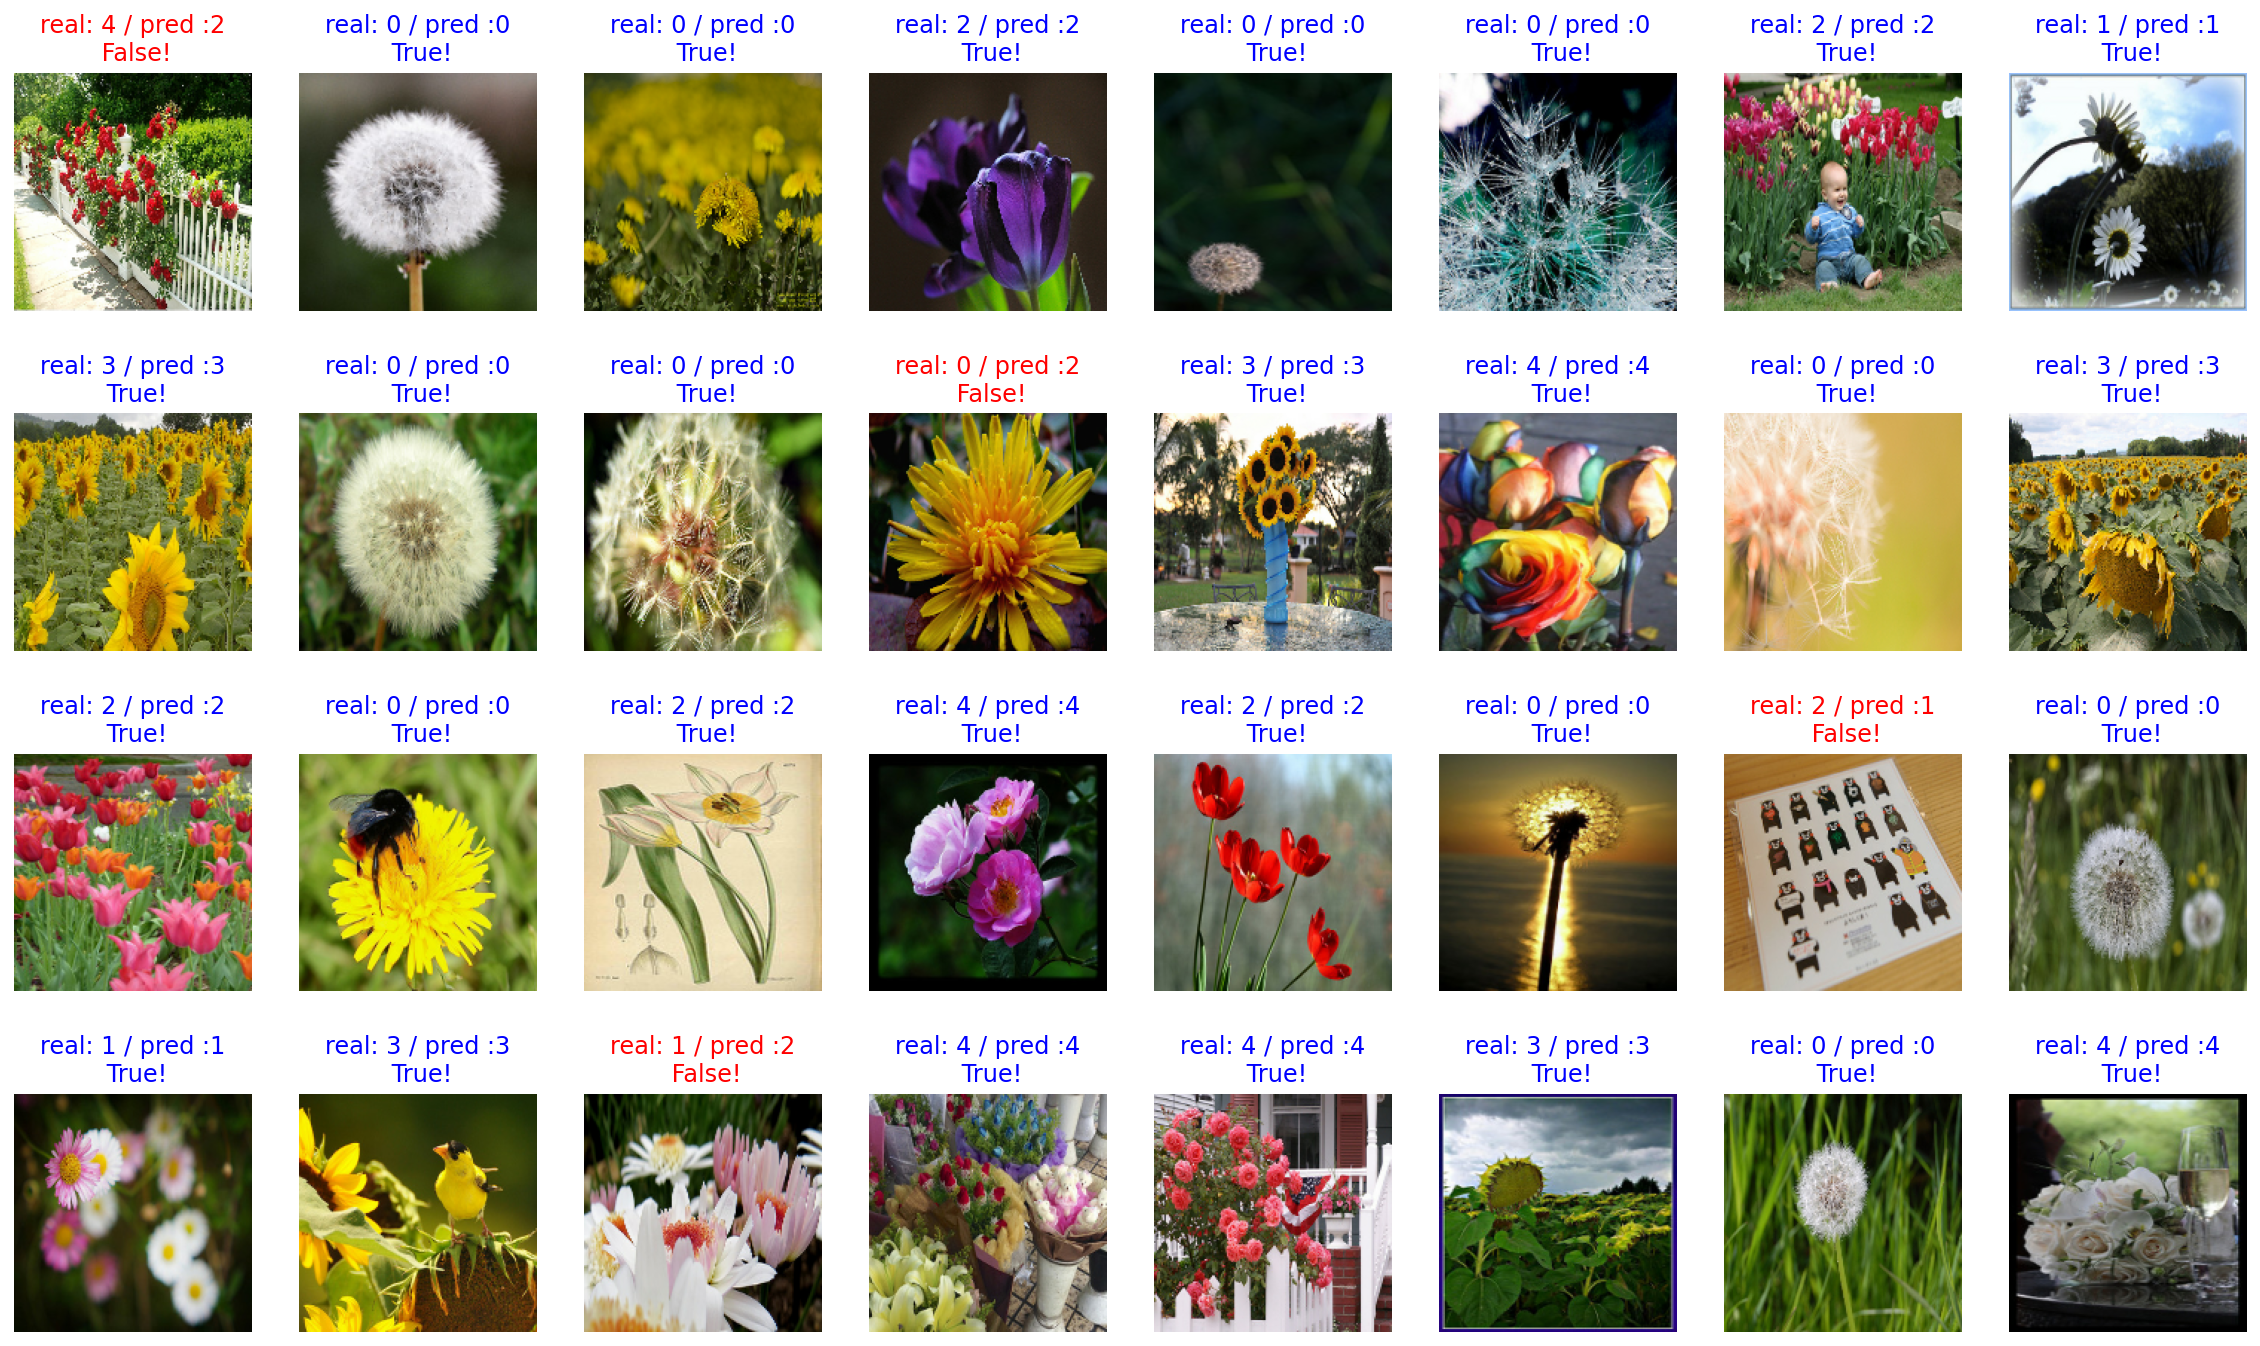

In [297]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [298]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):

    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)    

87.5


**모델 저장**

In [299]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/flower/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
    print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


**step 6. 모델 활용하기**

In [300]:
img_dir_path = os.getenv("HOME") + "/aiffel/flower/images"
os.path.exists(img_dir_path)

True

In [301]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


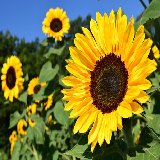

In [302]:
IMG_SIZE = 160
flower_image_path = os.path.join(img_dir_path, 'my_flower.jpg')

flower_image = load_img(flower_image_path, target_size=(IMG_SIZE, IMG_SIZE))
flower_image

In [303]:
flower_image = img_to_array(flower_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
flower_image.shape

(1, 160, 160, 3)

In [304]:
prediction = model.predict(flower_image)
prediction

array([[9.9010521e-01, 0.0000000e+00, 3.9310282e-15, 9.8947929e-03,
        0.0000000e+00]], dtype=float32)

In [305]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    label0_percentage = round(prediction[0] * 100)
    label1_percentage = round(prediction[1] * 100)
    label2_percentage = round(prediction[2] * 100)
    label3_percentage = round(prediction[3] * 100)
    label4_percentage = round(prediction[4] * 100)
    
    print(f"This image seems {label0_percentage}% dandelion, and {label1_percentage}% daisy, and {label2_percentage}% tulips, and {label3_percentage}% sunflowers, and {label4_percentage}% roses")
    
    
    
    

This image seems 99.0% dandelion, and 0.0% daisy, and 0.0% tulips, and 1.0% sunflowers, and 0.0% roses


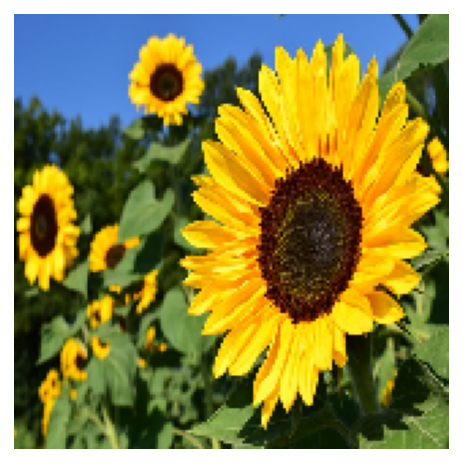

In [306]:
filename = 'my_flower.jpg'      # 이미지를 함수에 넣기

show_and_predict_image(img_dir_path, filename)

---

### 정리
- VGG16모델의 정확도: 78.125%
- VGG19모델의 정확도: 84.375    
<br/>
- VGG16 모델에 Batch_Normalization_layer 추가한 정확도: 87.5%
- VGG19 모델에 Batch_Normalization_layer 추가한 정확도: 81.25%    
<br/>
- VGG16 accuracy: 78.125% -> Batch_Normalization_layer 추가 -> VGG16 accuracy: 87.5% >> **정확도 증가**
- VGG19 accuracy: 84.375% -> Batch_Normalization_layer 추가 -> VGG19 accuracy: 81.25% >> **정확도 감소**    
<br/>    

### 결과
- 딥러닝 모델 2가지 사용하여 비교 (VGG16 vs VGG19)   
<br/>    

**[Accuracy 비교]**
- 기본 모델: VGG16 < **VGG19**
- Batch_Normalization_layer 추가 모델: **VGG16** > VGG19   
<br/>    

**=> VGG16모델**에 **Batch_Normalization_layer**를 딥러닝 레이어에 추가하는 것이 가장 큰 효과를 얻고 **높은 Accuracy**를 얻음